In [108]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import sklearn
from sklearn.linear_model import LinearRegression 

In [109]:
traindata = pd.read_csv('data/train.csv')
testdata = pd.read_csv('data/test.csv')
print ("Train data shape:", traindata.shape)
print ("Test data shape:", testdata.shape)

Train data shape: (1460, 81)
Test data shape: (1459, 80)


### 处理缺失值

In [110]:
# 删除缺失值百分比大于0.4的5个columns
traindata = traindata.drop(['Alley', 'FireplaceQu', 
                            'PoolQC', 'Fence', 'MiscFeature'], axis=1)
testdata = testdata.drop(['Alley', 'FireplaceQu', 
                          'PoolQC', 'Fence', 'MiscFeature'], axis=1)

### 除去异常值

In [111]:
traindata = traindata[traindata['GarageArea'] < 1200]
traindata = traindata[traindata['GrLivArea'] < 4500]
traindata = traindata[traindata['TotalBsmtSF'] < 3000]
traindata = traindata[traindata['1stFlrSF'] < 3000]

### DataFrame.interpolate()方法：用平均值填充缺失的值，然后将结果分配给data

In [112]:
data = traindata.select_dtypes(include=[np.number]).interpolate().dropna()

### one-hot编码转换非数字特征

In [113]:
traindata['street'] = pd.get_dummies(traindata.Street, drop_first=True)
testdata['street'] = pd.get_dummies(traindata.Street, drop_first=True)

traindata['Utilities'] = pd.get_dummies(traindata.Utilities, drop_first=True)
testdata['Utilities'] = pd.get_dummies(traindata.Utilities, drop_first=True)

traindata['CentralAir'] = pd.get_dummies(traindata.CentralAir, drop_first=True)
testdata['CentralAir'] = pd.get_dummies(traindata.CentralAir, drop_first=True)

Encoded: 

1    1446
0       5
Name: street, dtype: int64
Encoded: 

0    1450
1       1
Name: Utilities, dtype: int64
Encoded: 

1    1356
0      95
Name: CentralAir, dtype: int64


可归为两类：SaleCondition - 出售条件  表格显示其中间销售价格

In [114]:
# 选择所有SaleCondition等于Patrial并分配值的房屋1，否则（other）分配0
def encode(x): return 1 if x == 'Partial' else 0
traindata['condition'] = traindata.SaleCondition.apply(encode)
testdata['condition'] = testdata.SaleCondition.apply(encode)



DataFrame.interpolate()方法：用平均值填充缺失的值，然后将结果分配给data

In [115]:
data = traindata.select_dtypes(include=[np.number]).interpolate().dropna()

In [116]:
#检查所有的列是否有0个空值。
sum(data.isnull().sum() != 0)

0

## 建立一个线性模型
我们将分离功能和目标变量进行建模。
* 使用np.log()上面解释的方法来转换模型的y变量。
* data.drop([features], axis=1)方法来排除列

In [117]:
y = np.log(traindata.SalePrice)
X = data.drop(['SalePrice', 'Id'], axis=1)

## 使用scikit-learn的train_test_split()功能来创建一个训练集和一个保留集

In [118]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, random_state=42, test_size=.33)

实例化一个线性回归模型

In [119]:
from sklearn import linear_model
lr = linear_model.LinearRegression()
# 拟合模型
model = lr.fit(X_train, y_train)

## 评估模型的性能

In [120]:
print ("R^2 is:", model.score(X_test, y_test))

R^2 is: 0.885237400394


## 预测模型

* model.predict()方法将返回给定一组预测变量的预测列表。model.predict()在拟合模型后使用。
* `mean_squared_error`函数需要两个数组并计算`rmse`

In [121]:
predictions = model.predict(X_test)
from sklearn.metrics import mean_squared_error
print ('RMSE is:', mean_squared_error(y_test, predictions))

RMSE is: 0.0182298623277


* `RMSE`：测量我们的预测值和实际值之间的距离

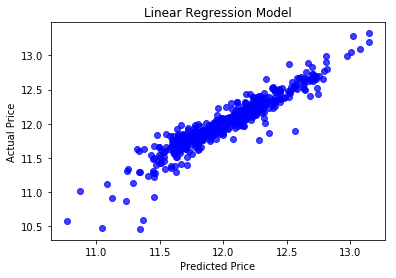

In [122]:
actual_values = y_test
plt.scatter(predictions, actual_values, alpha=.75,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')
plt.show()

* 如果我们的预测值与实际值相同，则该图将是直线，y=x因为每个预测值x将等于每个实际值y。

## 尝试改进模型

再次实例化模型。`Ridge Regularization`模型采用一个参数`alpha`来控制正则化的强度。
* `linear_model.Ridge()`带有l2正则化的线性最小二乘。

In [133]:
for i in range (-2, 3):
    alpha = 5**i
    rm = linear_model.Ridge(alpha=alpha)
    ridge_model = rm.fit(X_train, y_train)
    preds_ridge = ridge_model.predict(X_test)
    print('Ridge Regularization with alpha = {}'.format(alpha))
    print ('R^2 is: {}\nRMSE is: {}\n'.format(
                    ridge_model.score(X_test, y_test),
                    mean_squared_error(y_test, preds_ridge)))

Ridge Regularization with alpha = 0.04
R^2 is: 0.8852309490936728
RMSE is: 0.018230887106930622

Ridge Regularization with alpha = 0.2
R^2 is: 0.885207216434359
RMSE is: 0.01823465700333807

Ridge Regularization with alpha = 1
R^2 is: 0.8851277491836838
RMSE is: 0.01824728025380776

Ridge Regularization with alpha = 5
R^2 is: 0.8851256011993143
RMSE is: 0.01824762145781911

Ridge Regularization with alpha = 25
R^2 is: 0.8856952124158012
RMSE is: 0.018157139592711664



## 提交
我们需要创建一个csv包含数据集中SalePrice每个观测值的预测值test.csv。

第一列必须包含来自测试数据的ID

In [134]:
submission = pd.DataFrame()
submission['Id'] = testdata.Id
feats = testdata.select_dtypes(
        include=[np.number]).drop(['Id'], axis=1).interpolate()

产生预测并把预测转换成正确的形式
* 之前采用`np.log()`转换数据，现在要用`np.exp()`把数据转回来

In [135]:
predictions = model.predict(feats)
final_predictions = np.exp(predictions)

In [136]:
print ("Original predictions are: \n", predictions[:5], "\n")
print ("Final predictions are: \n", final_predictions[:5])

Original predictions are: 
 [ 11.72487913  11.94466004  12.06694059  12.1838932   12.10801684] 

Final predictions are: 
 [ 123609.06110402  153992.63191921  174022.62357968  195612.94237716
  181319.66270661]


查看预测结果

In [137]:
submission['SalePrice'] = final_predictions
submission.head()

,Id,SalePrice
0,1461,123609.061104
1,1462,153992.631919
2,1463,174022.623580
3,1464,195612.942377
4,1465,181319.662707


保存预测结果到`csv`文件

In [138]:
submission.to_csv('test.csv', index=False)

[提交页面](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/submit)